In [1]:
from detector import detectText

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from imutils.object_detection import non_max_suppression

import h5py

import scipy.io
import cv2

import numpy as np
import copy
import time
import pandas as pd
import os

import pytesseract

etiquetas = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

### Nuestros modelos

In [2]:
model_v1 = keras.models.load_model("textRecognitionModel_V1")
model_v2 = keras.models.load_model("textRecognitionModel_V2")

### Deteccion de texto

Vamos a detectar primero el texto en una imagen y luego pasaremos a reconocerlo

In [12]:
im = cv2.imread("jojos.jpg")
imText, bounds = detectText(im)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imText = cv2.cvtColor(imText, cv2.COLOR_BGR2RGB)

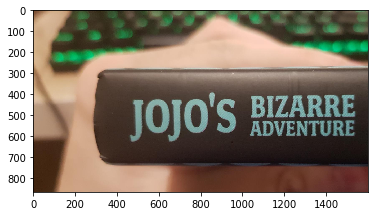

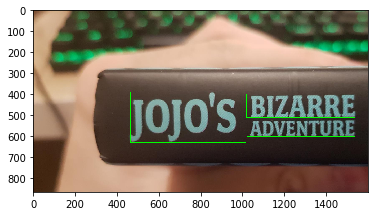

True

In [13]:
plt.imshow(im)
plt.show()

plt.imshow(imText)
plt.show()

cv2.imwrite("imText.jpg", cv2.cvtColor(imText, cv2.COLOR_RGB2BGR))

Zonas donde aparece texto recortadas

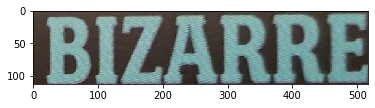

True

In [14]:
zonas = []
for b in bounds:
    zonas.append(im[b[1]:b[3], b[0]:b[2]])

zona = zonas[1]
plt.imshow(zona) # la zona que me interesa
plt.show()
cv2.imwrite("zonaQueQuieroAnalizar.jpg", cv2.cvtColor(zona, cv2.COLOR_RGB2BGR))

Ahora vamos a sacar los caracteres de la zona, para ello:
<ol>
  <li>Encuentro los contornos</li>
  <li>Ordeno los contornos</li>
  <li>Los guardo en un array</li>
</ol>

In [25]:
im = zona
copia = copy.deepcopy(zona)

imgray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
imgray = cv2.medianBlur(imgray,15)

_, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
charsim = []

for i, ctr in enumerate(sorted_ctrs):
    if cv2.contourArea(ctr) < 1000:
        continue
    
    x, y, w, h = cv2.boundingRect(ctr)

    roi = im[y:y+h, x:x+w]
    roi = cv2.resize(roi, (64,64))
    charsim.append(roi)
    cv2.rectangle(copia,(x,y),( x + w, y + h ),(0,255,0),2)

True

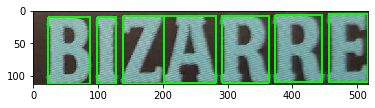

In [26]:
plt.imshow(copia)
cv2.imwrite("charsegmentation.jpg", cv2.cvtColor(copia, cv2.COLOR_RGB2BGR))

In [17]:
ims = []
imsdenoised = []
imssharped = []
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

for im in charsim:
    dst = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)
    ims.append(im)
    imsdenoised.append(dst)
    imssharped.append(cv2.filter2D(im, -1, kernel))
    
ims = np.array(ims)
imsdenoised = np.array(imsdenoised)
imssharped = np.array(imssharped)

Sin suavizar

In [27]:
pv1 = model_v1.predict(ims)
pv2 = model_v2.predict(ims)

for p in pv1:
    print(f"La version 1 dice: {etiquetas[np.argmax(p)]}")

print("")

for p in pv2:
    print(f"La version 2 dice: {etiquetas[np.argmax(p)]}")

La version 1 dice: 3
La version 1 dice: r
La version 1 dice: Z
La version 1 dice: A
La version 1 dice: R
La version 1 dice: R
La version 1 dice: E

La version 2 dice: 3
La version 2 dice: A
La version 2 dice: L
La version 2 dice: A
La version 2 dice: R
La version 2 dice: R
La version 2 dice: E


Suavizado

In [28]:
pv1 = model_v1.predict(imsdenoised)
pv2 = model_v2.predict(imsdenoised)

for p in pv1:
    print(f"La version 1 dice: {etiquetas[np.argmax(p)]}")

print("")

for p in pv2:
    print(f"La version 2 dice: {etiquetas[np.argmax(p)]}")

La version 1 dice: 3
La version 1 dice: L
La version 1 dice: Z
La version 1 dice: A
La version 1 dice: R
La version 1 dice: R
La version 1 dice: E

La version 2 dice: 3
La version 2 dice: L
La version 2 dice: L
La version 2 dice: A
La version 2 dice: R
La version 2 dice: R
La version 2 dice: E


Con algo de afilado para los bordes

In [29]:
pv1 = model_v1.predict(imssharped)
pv2 = model_v2.predict(imssharped)

for p in pv1:
    print(f"La version 1 dice: {etiquetas[np.argmax(p)]}")

print("")

for p in pv2:
    print(f"La version 2 dice: {etiquetas[np.argmax(p)]}")

La version 1 dice: B
La version 1 dice: E
La version 1 dice: e
La version 1 dice: H
La version 1 dice: J
La version 1 dice: R
La version 1 dice: E

La version 2 dice: R
La version 2 dice: x
La version 2 dice: a
La version 2 dice: A
La version 2 dice: R
La version 2 dice: R
La version 2 dice: E


## Benchmarks datasets

Bueno, tenemos ya los modelos y vamos a testearlos con datos de otros datasets. En los conjuntos de validación del Chars74K tenemos un 85% de accuracy con la v1 y un 87% con la v2.

Primero voy a cargar los datasets, el primero sería para los números: el MNIST

In [89]:
(X_trainMNIST, Y_trainMNIST), (X_testMNIST, Y_testMNIST) = mnist.load_data()
MNISTim = np.concatenate([X_trainMNIST, X_testMNIST], axis=0)
MNISTlabels = np.concatenate([Y_trainMNIST, Y_testMNIST], axis=0)

MNISTim = [cv2.resize(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), (64,64)) for im in MNISTim]
MNISTim = np.array(MNISTim)

In [67]:
test_loss, test_acc = model_v1.evaluate(MNISTim,  MNISTlabels, verbose=2)

print('\nTest accuracy version 1:', test_acc)

test_loss, test_acc = model_v2.evaluate(MNISTim,  MNISTlabels, verbose=2)

print('\nTest accuracy version 2:', test_acc)

2188/2188 - 158s - loss: 4.1659 - accuracy: 0.1648

Test accuracy version 1: 0.1647571474313736
2188/2188 - 160s - loss: 7.8597 - accuracy: 0.0929

Test accuracy version 2: 0.09292857348918915


El segundo dataset es el de las letras, el NIST.

In [3]:
df = pd.read_csv("D:/Datasets/A_Z Handwritten Data.csv", header=None)
df = pd.DataFrame.rename(df, columns={0:"label"})
df.head()

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
NIST_labels = df['label']
NIST_labels = NIST_labels.to_numpy()
NIST_labels += 10
NIST_data = df.iloc[:, 1:]
NIST_data = NIST_data.to_numpy()
NIST_data = [im.reshape((28,28)).astype('uint8') for im in NIST_data]
NIST_data = [cv2.cvtColor(cv2.resize(im, (64,64)), cv2.COLOR_GRAY2RGB) for im in NIST_data]
NIST_data= np.array(NIST_data)

(372451, 64, 64, 3)

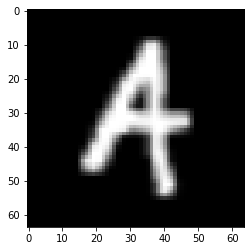

In [5]:
plt.imshow(NIST_data[0])
NIST_data.shape

In [6]:
x_train, x_test, y_train, y_test = train_test_split(NIST_data, NIST_labels, test_size=0.2, random_state=42)

In [8]:
test_loss, test_acc = model_v1.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy version 1:', test_acc)

test_loss, test_acc = model_v2.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy version 2:', test_acc)

2328/2328 - 196s - loss: 2.2752 - accuracy: 0.4185

Test accuracy version 1: 0.41852036118507385
2328/2328 - 167s - loss: 3.6647 - accuracy: 0.4692

Test accuracy version 2: 0.4692244827747345


Ahora probamos el dataset SVHN

In [78]:
mat = scipy.io.loadmat('train_32x32.mat')
x_train = np.array(mat['X'])
y_train = np.array(mat['y'])
x_train = np.moveaxis(x_train, -1, 0)

x_train = [cv2.resize(im, (64,64)) for im in x_train]

x_train = np.array(x_train)
y_train = [l[0] for l in y_train]
y_train = np.array(y_train)

mat = scipy.io.loadmat('test_32x32.mat')
x_test = mat['X']

x_test = np.moveaxis(x_test, -1, 0)
x_test = [cv2.resize(im, (64,64)) for im in x_test]

y_test = mat['y'] 

x_test = np.array(x_test)
y_test = [l[0] for l in y_test]
y_test = np.array(y_test)

In [82]:
test_loss, test_acc = model_v1.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy version 1:', test_acc)

test_loss, test_acc = model_v2.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy version 2:', test_acc)

814/814 - 61s - loss: 4.1956 - accuracy: 0.1237

Test accuracy version 1: 0.12365549802780151
814/814 - 57s - loss: 5.2701 - accuracy: 0.0957

Test accuracy version 2: 0.09572833776473999
